In [1]:
# packages
import os, time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# imbalanced dataset
import imblearn
from imblearn.over_sampling import SMOTE #(Synthetic Minority Oversamping TEchnique)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#!pip install babyplots
#from babyplots import Babyplot

In [3]:
# loading data
data_dir = "../input/breast-cancer-wisconsin-data/data.csv"

df  = pd.read_csv(data_dir)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
df.isnull().values.any() # no missing values

True

In [6]:
# Every feature variables are float numbers, ID - id of the case/patient

df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

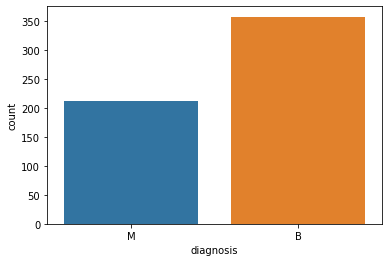

In [7]:
sns.countplot(x="diagnosis", data=df);

In [8]:
# Not very-unbalanced dataset - still their is disparity in the number of Malignant and Benign records
# converting M and B into 1 and 0
df.diagnosis = df.diagnosis.map({"M": 1, "B": 0})

In [9]:
# Label Encoder?

In [10]:
#df["Unnamed: 32"].values
# This seems an empty columns: drop it

# Since we don't need ID for this analysis: not relating any results to actual ID for now
for col in ["id", "Unnamed: 32"]: 
    df = df.drop(columns=[col])
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


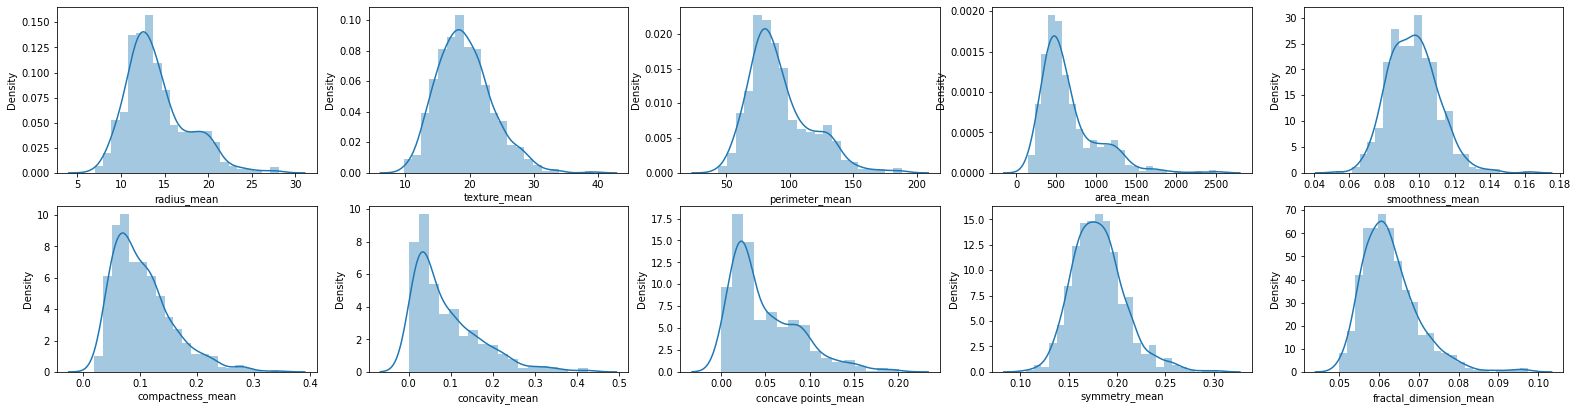

In [12]:
# the features seem derived from few variables' mean, standard deviation and worst cases
# Let us plot their distributions into three different groups

mean_features = []
for f in df.columns:
    if "mean" in f:
        mean_features.append(f)
# plotting mean variables
plt.figure(figsize = (27, 36))
for i in range(10):
    plt.subplot(10, 5, i+1)
    sns.distplot(df[mean_features[i]], kde=True)
plt.show()

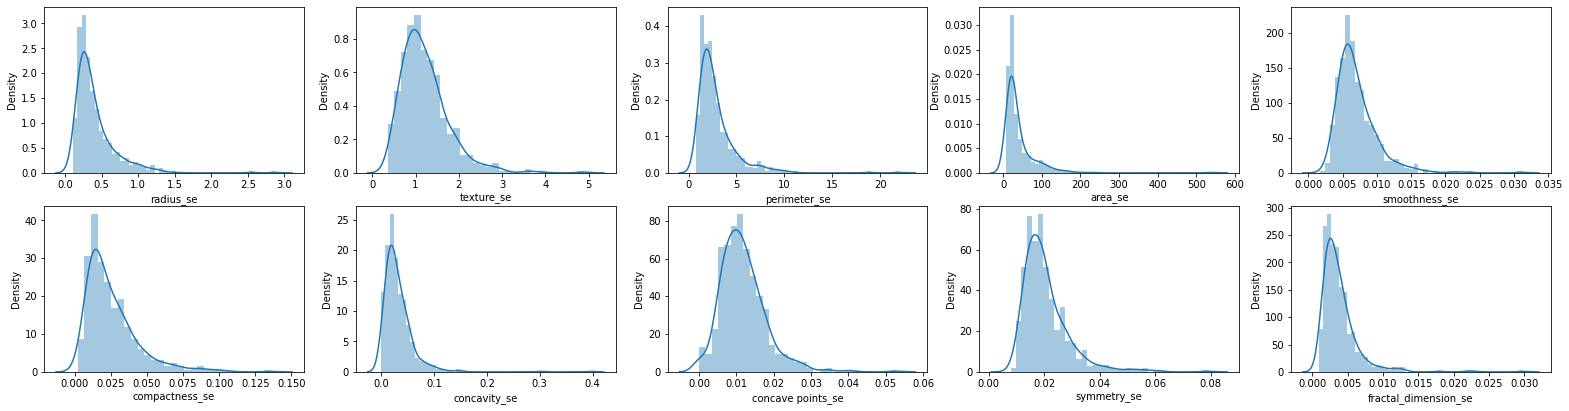

In [13]:
se_features = []
for f in df.columns:
    if "se" in f:
        se_features.append(f)
# plotting se variables
plt.figure(figsize = (27, 36))
for i in range(10):
    plt.subplot(10, 5, i+1)
    sns.distplot(df[se_features[i]], kde=True)
plt.show()

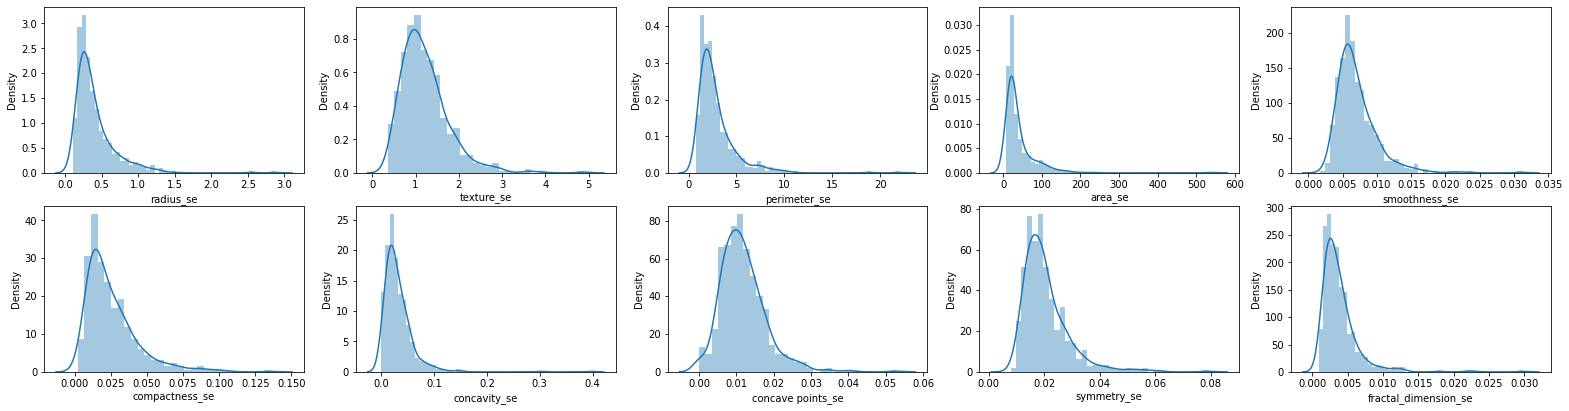

In [14]:
worst_features = []
for f in df.columns:
    if "se" in f:
        worst_features.append(f)
# plotting worst variables
plt.figure(figsize = (27, 36))
for i in range(10):
    plt.subplot(10, 5, i+1)
    sns.distplot(df[worst_features[i]], kde=True)
plt.show()

In [15]:
# Swarmplot: to see the variance/distribution of each featuress: standardized value : z = (x-m)/s

def swarmplot_features(findex_min, findex_max):
    sns.set_theme() #(style="darkgrid", palette="deep")
    sns.set_context("talk")

    y = df.diagnosis
    data = df.drop(columns=["diagnosis"])
    data_std = (data - data.mean()) / (data.std())     # standardization
    data = pd.concat([y, data_std.iloc[:, findex_min:findex_max]], axis=1)
    data = pd.melt(data,id_vars="diagnosis",
                        var_name="features",
                        value_name='value')

    plt.figure(figsize=(18,8))
    sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
    plt.xticks(rotation=90)
    plt.show()

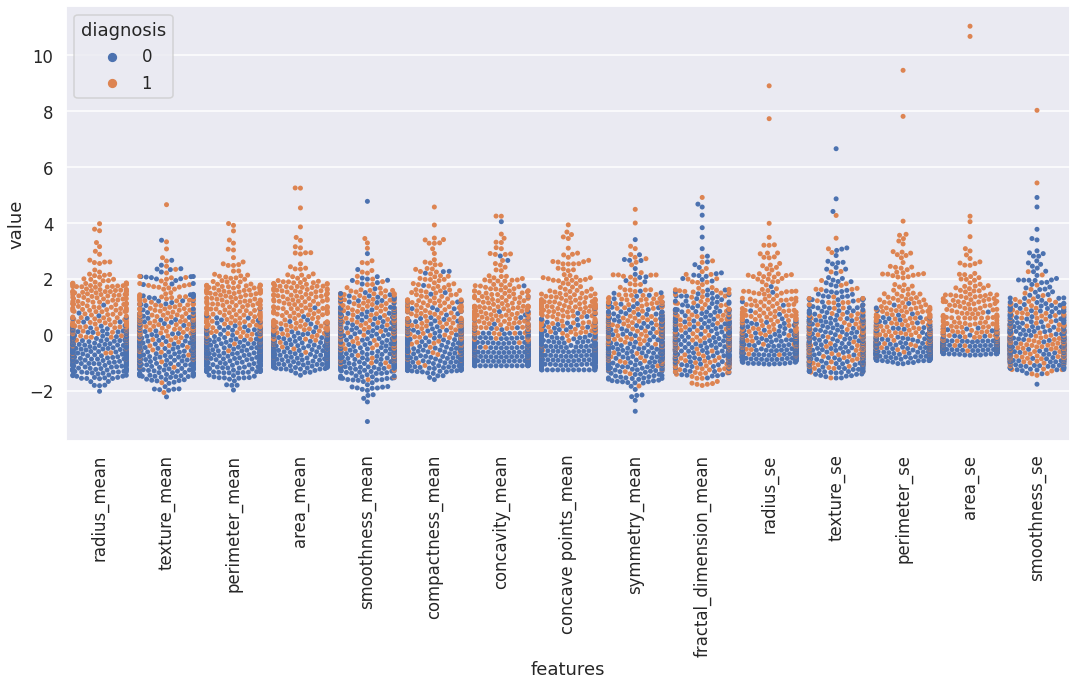

In [16]:
swarmplot_features(0, 15)

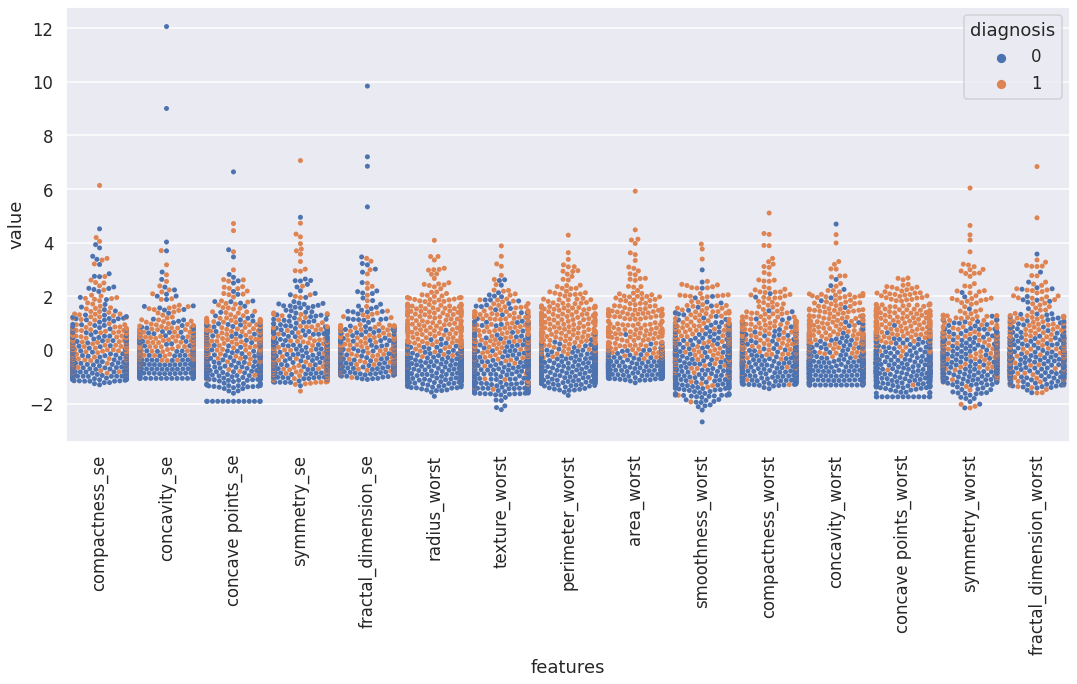

In [17]:
swarmplot_features(15, 30)

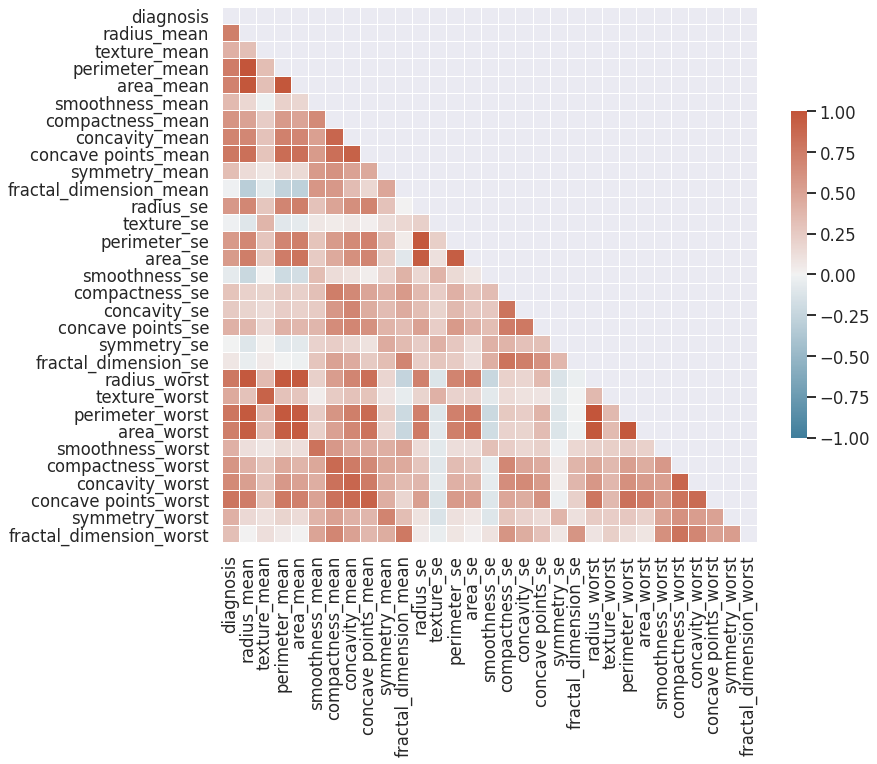

In [18]:
# correlation between the features:

corr = df.corr()
# mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12, 12))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [19]:
# We see strong correlation among the features as well as that of features with the target variable - which is a categorical variable. 
# We understand the correlation between the continuous and categorical (diagnois) varibles by: point-bisereal correlation, logistic regression etc. 

In [20]:
# highly correlated features

highly_correlated_features = []

for i, idx in enumerate(corr.index):
    for j, col in enumerate(corr.columns):
        if j <= i: continue
        if abs(corr.loc[idx, col]) > 0.90:
            print((idx, col), ":--> ", round(corr.loc[idx, col], 3))
            highly_correlated_features.append((idx, col))
len(highly_correlated_features)

('radius_mean', 'perimeter_mean') :-->  0.998
('radius_mean', 'area_mean') :-->  0.987
('radius_mean', 'radius_worst') :-->  0.97
('radius_mean', 'perimeter_worst') :-->  0.965
('radius_mean', 'area_worst') :-->  0.941
('texture_mean', 'texture_worst') :-->  0.912
('perimeter_mean', 'area_mean') :-->  0.987
('perimeter_mean', 'radius_worst') :-->  0.969
('perimeter_mean', 'perimeter_worst') :-->  0.97
('perimeter_mean', 'area_worst') :-->  0.942
('area_mean', 'radius_worst') :-->  0.963
('area_mean', 'perimeter_worst') :-->  0.959
('area_mean', 'area_worst') :-->  0.959
('concavity_mean', 'concave points_mean') :-->  0.921
('concave points_mean', 'concave points_worst') :-->  0.91
('radius_se', 'perimeter_se') :-->  0.973
('radius_se', 'area_se') :-->  0.952
('perimeter_se', 'area_se') :-->  0.938
('radius_worst', 'perimeter_worst') :-->  0.994
('radius_worst', 'area_worst') :-->  0.984
('perimeter_worst', 'area_worst') :-->  0.978


21

Many of the features are highly correlated to each other. If we want to fit a linear model like Logistic Regression, we must to do careful features selection to remove the strong multi-colinearity in the data. 

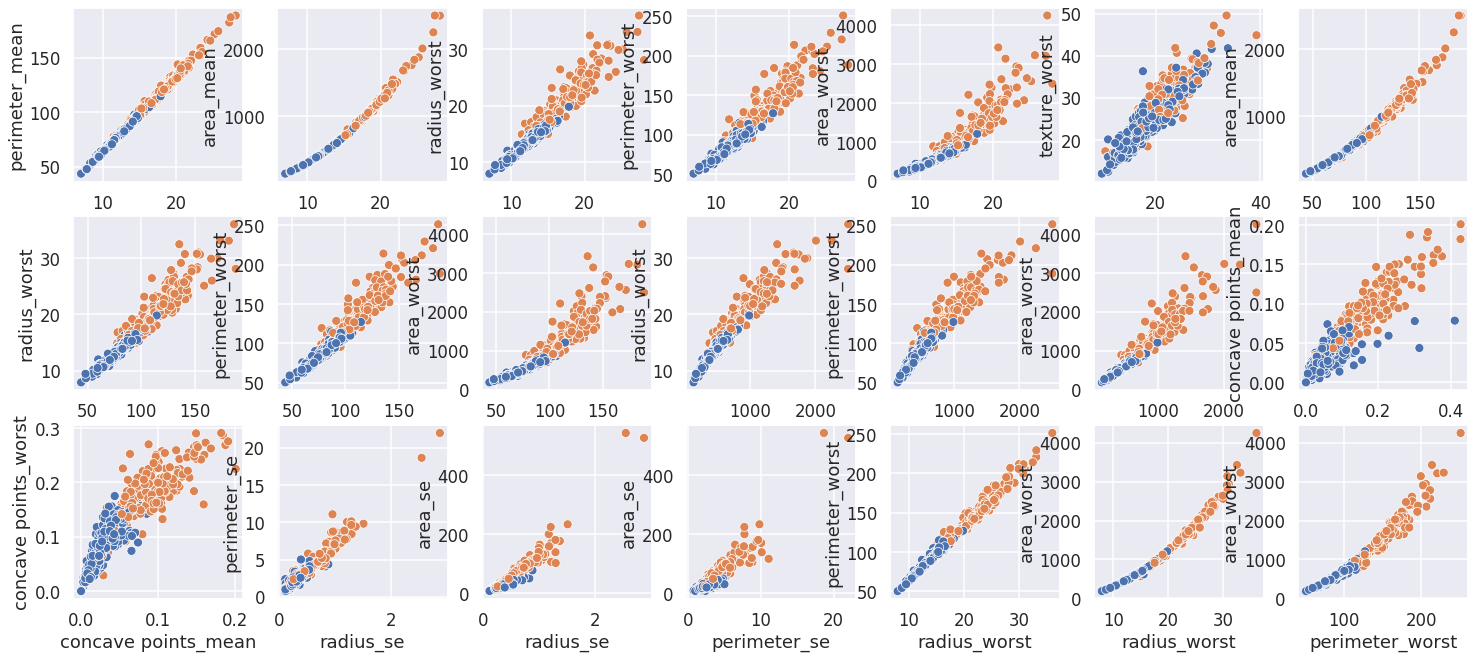

In [21]:
plt.figure(figsize = (25, 80))
for i in range(21):
    fs = highly_correlated_features[i]
    plt.subplot(21, 7, i+1)
    sns.scatterplot(x=fs[0], y=fs[1], hue="diagnosis", data=df, legend=False)
plt.show()

In [22]:
# We can see that these highly correlated features are also already very important features: that can separate the records into the two target classes

In [23]:
# Radar plot: separate two classes based on few important variables
def radar_plot_class(df):
    '''
    In binary classification problem:
        df: feature dataframe
        edges: select few most important columns/features --> plot radar chart to show separation between the two classes
    '''
    
    target = "diagnosis"
    if target not in df.columns:
        raise ValueError("If prediction target variable is named different, name it target!")
    
    corr = df.corr()[target].sort_values(ascending=False)

    edges = list(corr.index)[:9]
    
    #edges = highly_correlated_features
    
    if target in edges:
        edges.remove(target)
    
    # stadardization of features: for scaled radii as standard deviation of features
    df_scaled = df[edges]
    df_scaled = StandardScaler().fit_transform(df_scaled)

    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = edges
    df_scaled[target] = list(df[target].values)

    # radius of the chart
    radii_0 = []
    radii_1 = []
    for edge in edges:
        
        value1 = df_scaled[df_scaled[target] == 1][edge].mean()
        value0 = df_scaled[df_scaled[target] == 0][edge].mean()
        
        radii_1.append(value1)
        radii_0.append(value0)
            
    edge_labels = [i.upper() for i in edges]

    # plotting
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=radii_0,
        theta=edge_labels,
        fill='toself',
        name='Negative'
    ))
    fig.add_trace(go.Scatterpolar(
        r=radii_1,
        theta=edge_labels,
        fill='toself',
        name='Positive'
    ))
    fig.update_layout(
    polar=dict(
            radialaxis=dict(
            visible=True,
            range=[-1, 1.1]
        )),
    showlegend=True
    )
    fig.show()
    
radar_plot_class(df)

In [24]:
y = df.diagnosis
X = df.drop(columns=["diagnosis"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

total variance by principle components:  0.99822


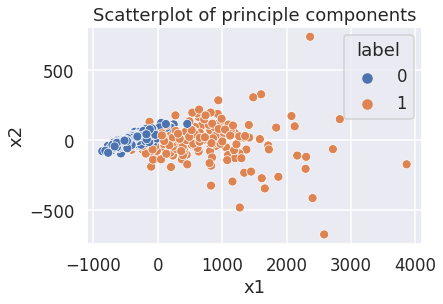

In [25]:
# Dimensionality reduction with PCA

pca = PCA(n_components=2, svd_solver='full')

pca.fit(X)
print("total variance by principle components: ", round(pca.explained_variance_ratio_.sum(), 5))

X_red = pca.transform(X)
tmp = pd.DataFrame(data={"x1": X_red[:, 0], "x2": X_red[:, 1], "label": y})

sns.scatterplot(x="x1", y="x2", hue="label", data=tmp);
plt.title("Scatterplot of principle components");

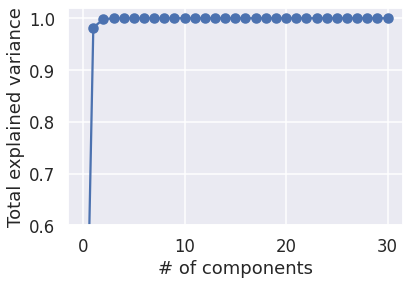

In [26]:
# total explained variance by the num of components
num_components = []
total_variance = []
for n in range(31):
    pca = PCA(n_components=n, svd_solver="full", random_state=21)
    pca.fit(X)
    
    variance = pca.explained_variance_ratio_.sum()
    
    num_components.append(n)
    total_variance.append(variance)

plt.scatter(num_components, total_variance)
plt.plot(num_components, total_variance)
plt.xlabel('# of components')
plt.ylabel('Total explained variance')
plt.ylim(0.6, 1.02)
plt.show()

In [27]:
pca.explained_variance_ratio_

array([9.82044672e-01, 1.61764899e-02, 1.55751075e-03, 1.20931964e-04,
       8.82724536e-05, 6.64883951e-06, 4.01713682e-06, 8.22017197e-07,
       3.44135279e-07, 1.86018721e-07, 6.99473205e-08, 1.65908880e-08,
       6.99641650e-09, 4.78318306e-09, 2.93549214e-09, 1.41684927e-09,
       8.29577731e-10, 5.20405883e-10, 4.08463983e-10, 3.63313378e-10,
       1.72849737e-10, 1.27487508e-10, 7.72682973e-11, 6.28357718e-11,
       3.57302295e-11, 2.76396041e-11, 8.14452259e-12, 6.30211541e-12,
       4.43666945e-12, 1.55344680e-12])

In [28]:
# 3D plot with babyplots: 3 PCA components
# pca = PCA(n_components=3, svd_solver='full')

# pca.fit(X)
# print("total variance by principle components: ", round(pca.explained_variance_ratio_.sum(), 3))

# X_red = pca.transform(X)
# tmp = pd.DataFrame(data={"x1": X_red[:, 0], "x2": X_red[:, 1], "x3": X_red[:, 2], "label": y})

# coords = tmp.iloc[:,0:3].values.tolist()
# clusts = tmp.label.values.tolist()

# bp = Babyplot(background_color="#000000ff")
# bp.add_plot(coords, "pointCloud", "categories", clusts, {"colorScale": "spring", "size": 2, "intensityMode": "gamma"})

# bp

In [29]:
y_train.value_counts()

0    263
1    163
Name: diagnosis, dtype: int64

In [30]:
# Oversampling minority class using SMOTE: Synthetic Minority Oversampling Technique
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [31]:
y_train.value_counts()  # Both class are equal in number

0    263
1    263
Name: diagnosis, dtype: int64

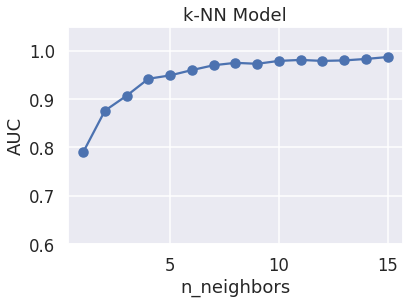

In [32]:
# Baseline model: k-NN
# This is highly separated data by class in many feature space, so kNN might already be a good model

# correlated features - non-zero covariates --> feature sclaing is not effective so use Mahalanobis distance

auc_list = []
n_neighbors_list = []

for n in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=n, weights="distance", metric="mahalanobis")
    knn.fit(X_train, y_train)
    auc_list.append(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]).round(3))
    n_neighbors_list.append(n)
plt.scatter(n_neighbors_list, auc_list)
plt.plot(n_neighbors_list, auc_list)
plt.ylim(0.6, 1.05)
plt.title("k-NN Model")
plt.xlabel("n_neighbors")
plt.ylabel("AUC")
plt.show();

In [33]:
knn = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="mahalanobis")
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test).ravel()

print(classification_report(y_test, y_pred))
print("AUC: ", roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]).round(3))

confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90        94
           1       0.94      0.63      0.76        49

    accuracy                           0.86       143
   macro avg       0.89      0.81      0.83       143
weighted avg       0.87      0.86      0.85       143

AUC:  0.948


array([[92,  2],
       [18, 31]])

In [34]:
# pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=21))  # base model with default parameters
# As we are only going to use RF, decision tree-based model, we are not using feature stadardization: should be done for other methods like NN, linear models etc.

model = RandomForestClassifier(random_state=21)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=21)

In [35]:
y_proba = model.predict_proba(X_test)[:, 1]

In [36]:
# tmp = pd.DataFrame(data={"predicted_proba": y_proba, "true": y_test})
# sns.histplot(x="predicted_proba", hue="true", data=tmp, bins=20, multiple="stack");

# Area under curve
roc_auc_score(y_test, y_proba)

0.9789405123751628

In [37]:
# We can see that: two classes are well separated based on the probability of confidence on the prediction. However, there are few cases where the model is predicting
# incorrect results. Since this dataset is small, we can't confirm the benefits of tuning the cutoff probability for dichotomous binary prediction. However, this can 
# be used to fine tune the cutoff and acheive the higher value of preferred metric depending upon the problem.

In [38]:
cutoff = 0.5
y_pred = (y_proba > cutoff).astype(int)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        94
           1       0.94      0.94      0.94        49

    accuracy                           0.96       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



In [40]:
# Let us do some hyperparameter tuning to create the model: then we can do few more results analysis to understand the model
# model.get_params()  # to find the list of the tunable parameters

In [41]:
# Feature selection: recursive feature elimination and cross validation

rf = RandomForestClassifier(random_state=21)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy')

rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Top features :', X_train.columns[rfecv.support_])

Optimal number of features : 30
Top features : Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


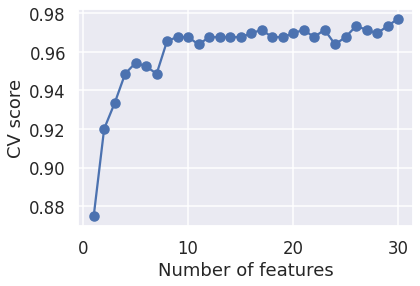

In [42]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features")
plt.ylabel("CV score")
plt.scatter(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [43]:
# Let us work further only with those selected 10 features
X_train = X_train[X_train.columns[rfecv.support_].tolist()]
X_test = X_test[X_test.columns[rfecv.support_].tolist()]
# y_train and y_test remain same

In [44]:
# Hyperparamters tuning with RF model: using selected features
# parameter space to search the best hyperparameters
random_grid = {  'criterion': ["gini", "entropy"],
                 'bootstrap': [True, False],
                 'max_depth': [3, 4, 5, 6, 7, 9, 11, 13, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [60, 80, 100, 120, 160, 200, 400, 800, 1000]
              }

RandomizedSearchCV is just a cheaper version of GridSearchCV that possibly covers the optimal range of parameter space with less number of runs. However, this method is entirely random and doesn't guarentee the optimized set of hyperparameters - as it doesn't remember anything from the previous run. 

Best approach is to use Bayesian hyperparameters optimization approaches. These algorithms keep track of past evaluation results which they use to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. As these methods choose the next set of hyperparameters in the informed manner, they quickly reaches the best set of parameters. Examples: hyperopt, optuna packages etc. 

In [45]:
X.columns[rfecv.support_]

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [46]:
%%time

rf = RandomForestClassifier()
clf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=21, n_jobs=-1)

#fitting on the full dataset: for hyperparameters tuning
# clf.fit(X[X.columns[rfecv.support_].tolist()], y)

CPU times: user 130 µs, sys: 0 ns, total: 130 µs
Wall time: 139 µs


In [47]:
# best model hyperparameters
# clf.best_params_

# saved:

params =   { 'n_estimators': 100,
             'min_samples_split': 2,
             'min_samples_leaf': 1,
             'max_features': 'auto',
             'max_depth': 6,
             'criterion': 'gini',
             'bootstrap': True
           }

In [48]:
# creating the best model: using hyperparameters obtained above
model = RandomForestClassifier(**params) #**clf.best_params_)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [49]:
y_proba = model.predict_proba(X_test)[:, 1]

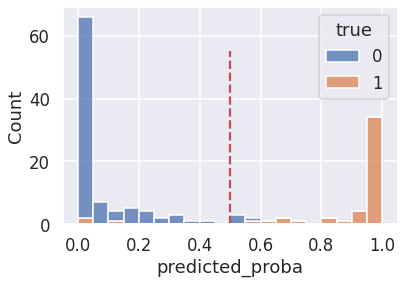

In [50]:
tmp = pd.DataFrame(data={"predicted_proba": y_proba, "true": y_test})
sns.histplot(x="predicted_proba", hue="true", data=tmp, bins=20, multiple="stack", );
plt.vlines(x=0.5, ymin=0, ymax=55, color='r', linestyle="--");

In [51]:
# Wrong predictions on following cases
err_tmp = pd.concat([tmp[(tmp.predicted_proba < 0.5) & (tmp.true == 1)], tmp[(tmp.predicted_proba >= 0.5) & (tmp.true == 0)]])
err_tmp

,predicted_proba,true
40,0.012400,1
38,0.100000,1
297,0.030508,1
500,0.542830,0
133,0.512304,0
128,0.542495,0
406,0.579537,0


In [52]:
X_test[X_test.index.isin(err_tmp.index.tolist())]  # wrong predictions on following instances

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
40,13.44,21.58,86.18,563.0,0.08162,0.06031,0.03110,0.02031,0.1784,0.05587,...,15.93,30.25,102.50,787.9,0.10940,0.20430,0.20850,0.11120,0.2994,0.07146
500,15.04,16.74,98.73,689.4,0.09883,0.13640,0.07721,0.06142,0.1668,0.06869,...,16.76,20.43,109.70,856.9,0.11350,0.21760,0.18560,0.10180,0.2177,0.08549
38,14.99,25.20,95.54,698.8,0.09387,0.05131,0.02398,0.02899,0.1565,0.05504,...,14.99,25.20,95.54,698.8,0.09387,0.05131,0.02398,0.02899,0.1565,0.05504
133,15.71,13.93,102.00,761.7,0.09462,0.09462,0.07135,0.05933,0.1816,0.05723,...,17.50,19.25,114.30,922.8,0.12230,0.19490,0.17090,0.13740,0.2723,0.07071
297,11.76,18.14,75.00,431.1,0.09968,0.05914,0.02685,0.03515,0.1619,0.06287,...,13.36,23.39,85.10,553.6,0.11370,0.07974,0.06120,0.07160,0.1978,0.06915
128,15.10,16.39,99.58,674.5,0.11500,0.18070,0.11380,0.08534,0.2001,0.06467,...,16.11,18.33,105.90,762.6,0.13860,0.28830,0.19600,0.14230,0.2590,0.07779
406,16.14,14.86,104.30,800.0,0.09495,0.08501,0.05500,0.04528,0.1735,0.05875,...,17.71,19.58,115.90,947.9,0.12060,0.17220,0.23100,0.11290,0.2778,0.07012


In [53]:
cutoff = 0.45
y_pred = (y_proba > cutoff).astype(int)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        94
           1       0.92      0.94      0.93        49

    accuracy                           0.95       143
   macro avg       0.94      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



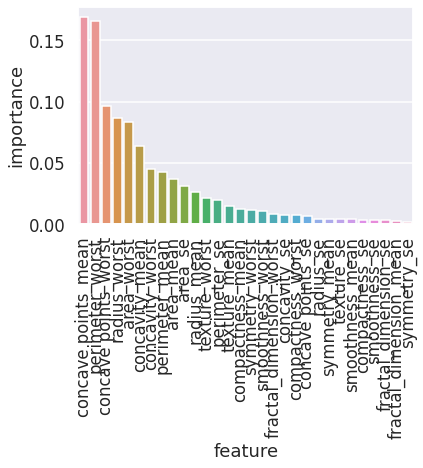

In [55]:
# Feature importance
tmp = pd.DataFrame(data={"feature": X_train.columns, "importance": model.feature_importances_})
tmp = tmp.sort_values(by=["importance"], ascending=False)

sns.barplot(x="feature", y="importance", data=tmp);
plt.xticks(rotation=90);

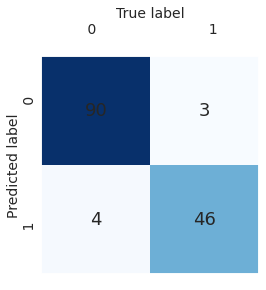

In [56]:
# helper function: plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    # confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    data = conf_matrix.transpose()  
    
    _, ax = plt.subplots()
    ax.matshow(data, cmap="Blues")
    # printing exact numbers
    for (i, j), z in np.ndenumerate(data):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    # axis formatting 
    plt.xticks([])
    plt.yticks([])
    plt.title("True label\n 0  {}     1\n".format(" "*18), fontsize=14)
    plt.ylabel("Predicted label\n 1   {}     0".format(" "*18), fontsize=14)
    
plot_confusion_matrix(y_test, y_pred);

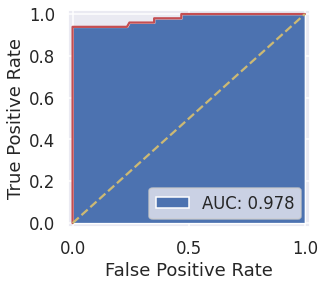

In [57]:
# helper function: ROC curve
def draw_roc_curve(y_true, y_proba):
    '''
       Plot and return ROC curve with appropriate labels and legend 
    
    '''
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    _, ax = plt.subplots()
    
    ax.plot(fpr, tpr, color='r');
    ax.plot([0, 1], [0, 1], color='y', linestyle='--')
    ax.fill_between(fpr, tpr, label=f"AUC: {round(roc_auc_score(y_true, y_proba), 3)}")
    ax.set_aspect(0.90)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim(-0.02, 1.02);
    ax.set_ylim(-0.02, 1.02);
    plt.legend()
    plt.show()

# plotting roc curve
draw_roc_curve(y_test, y_proba)

In [58]:
# SHAP values
import shap

In [59]:
explainer = shap.Explainer(model, X_train)
shap.initjs()

In [60]:
# Force plot
# Force plot
test_instance = X_test.values[0]

shap_values = explainer.shap_values(test_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], test_instance)

In [61]:
# Force plot
test_instance = X_test.values[6]

shap_values = explainer.shap_values(test_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], test_instance)

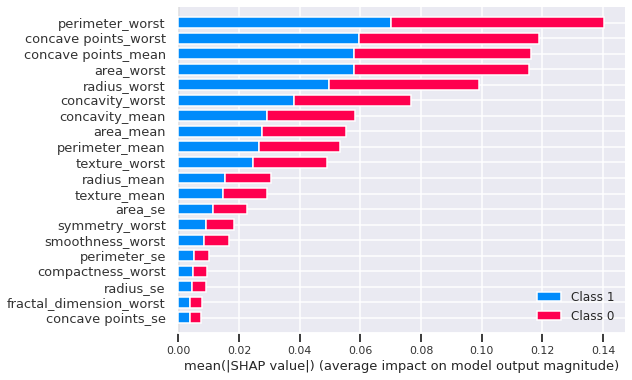

In [62]:
shap.summary_plot(explainer.shap_values(X_test, check_additivity=False), X_test, plot_type="bar", plot_size=(8, 6))

In [63]:
# shap_values = explainer(X_train, check_additivity=False)
# shap.plots.beeswarm(shap_values)

### Deep Learning Model

In [64]:
import keras
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, EarlyStopping
from tqdm.keras import TqdmCallback

model = keras.Sequential(
                  [
                    keras.layers.Dense(units=16, activation="relu", name="Input", input_dim=30),
                    keras.layers.Dropout(rate=0.1),
                    keras.layers.Dense(units=16, activation="relu", name="Hidden"),
                    keras.layers.Dropout(rate=0.1),
                    keras.layers.Dense(units=1, activation="sigmoid", name="Output"),
                  ]
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 16)                496       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
Hidden (Dense)               (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


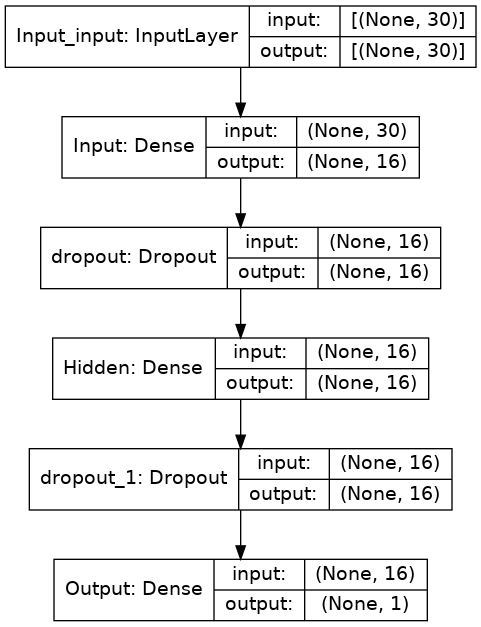

In [65]:
# visualaize the keras model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir="VR", expand_nested=True)

In [66]:
# compiling the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
y = df.diagnosis
X = df.drop(columns=["diagnosis"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# training
callbacks = [TqdmCallback(verbose=0), CSVLogger("../working/results.csv")]
model.fit(X, y, validation_split=0.2, batch_size=128, epochs=350, verbose=0, callbacks=callbacks);

0epoch [00:00, ?epoch/s]

In [68]:
results = pd.read_csv("../working/results.csv")
results.tail()

,epoch,accuracy,loss,val_accuracy,val_loss
345,345,0.914286,0.252615,0.894737,0.348236
346,346,0.912088,0.286795,0.894737,0.337049
347,347,0.914286,0.282845,0.894737,0.331355
348,348,0.898901,0.305874,0.885965,0.334354
349,349,0.912088,0.282878,0.885965,0.337903


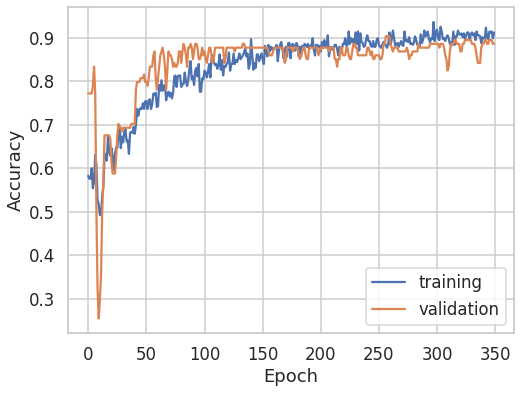

In [69]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(results.epoch.values, results.accuracy.values, label="training");
plt.plot(results.epoch.values, results.val_accuracy.values, label="validation");
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

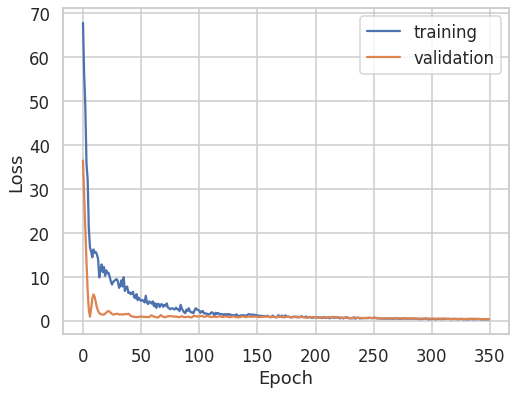

In [70]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(results.epoch.values, results.loss.values, label="training");
plt.plot(results.epoch.values, results.val_loss.values, label="validation");
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();